<br>
<hr>
**You open doors when you open books... doors that swing wide to unlimited horizons of knowledge, wisdom, and inspiration that will enlarge the dimensions of your life.** ~ Wilferd Peterson
<hr>
<br>

1. [Introduction](#Introduction:-Kuzushiji-Recognition)
2. [Data](#The-Data)
3. [Preparation](#Preparation)
4. [Useful functions](#Useful-functions)
5. [Visualize training data](#Visualize-training-data)
6. [Inspect single Kuzushiji Characters](#Inspect-Kuzushiji-Characters)
7. [EDA](#EDA)

## Introduction: Kuzushiji Recognition
Kuzushiji is a Japanese cursive writing style that has stopped being used 150 years ago when the Japanese education system had a reformation. Kuzushiji has been used for over 1000 years. A million books have been published and more than one billion unregistered books have been written in Kuzushiji
Now only 0.01% of Japanese natives are able to read Kuzushiji and thus it is hard to transcribe the documents into modern Japanese characters.
The advancements in Machine Learning and Computer Vision are the perfect opportunity to finally solve this challenge.

Our task is to build a model that can locate and classify Kuzushiji-characters on images.

## The Data

### train.csv
* image_id: The filename without the filextension to uniquely identify each image
* labels: A string containing all labels for the given image. This can be used to draw a bounding box around each character on the image. The string contains each Unicode character, X-coordinate, Y-coordinate, With and Heigt. The information are space seperated.

### sample_submission.csv

* image_id: The filename without the filextension to uniquely identify each image
* labels

### unicode_translations.csv
mapping unicode ID and Japanese character

### train_images.zip
Training images. Thanks to train.csv we have the information about each Kuzushiji character on there

### test_images.zip
Testing images. Our task is to locate each character on the image and classify them afterwards.

I'm happy to help everyone, so if you have any questions or explanations weren't completely clear, don't hesitate to ask in the comments. Upvotes are as always appreciated if you learned something new :)

TODO:
- group functions
- add more comments
- remove all unuseful lines of code
- explain SVD and tSNE

## Preparation

In [1]:
%matplotlib inline

# hide warnings
import warnings
warnings.simplefilter('ignore')

import os
import shutil
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from PIL import Image, ImageDraw, ImageFont
import cv2

import regex as re
import math
import random

from itertools import compress

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.utils.data_utils import GeneratorEnqueuer

from tqdm import tnrange, tqdm_notebook

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

Using TensorFlow backend.


Setup font, so that characters can be displayed

In [2]:
# download a font that can display the characters

# From https://www.google.com/get/noto/
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

# enable font for matplotlib
import matplotlib.font_manager as font_manager
path = './NotoSansCJKjp-Regular.otf'
prop = font_manager.FontProperties(fname=path)

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
NotoSansCJKjp-hinte 100%[===================>] 115.49M  40.7MB/s    in 2.8s    


In [3]:
# save and inspect input directory
INPUT = Path("../input/kuzushiji-recognition")
print(os.listdir(INPUT))

# save and inspect sub-folders of input directory
TEST = INPUT/'test_images'
TRAIN = INPUT/'train_images'
print(os.listdir(TEST)[:3])
print(os.listdir(TRAIN)[:3])

#Check the number of training and testing images
print(f"images in training dataset: {len(os.listdir(TRAIN))}")
print(f"images in test dataset: {len(os.listdir(TEST))}")

['test_images', 'train.csv', 'sample_submission.csv', 'unicode_translation.csv', 'train_images']
['test_53ae5e93.jpg', 'test_8ce7fab8.jpg', 'test_fb76e0b4.jpg']
['100249537_00064_2.jpg', '200004148_00010_1.jpg', 'umgy004-044.jpg']
images in training dataset: 3881
images in test dataset: 4150


In [4]:
#Inspect train.csv
train_df = pd.read_csv(INPUT/'train.csv')
train_df.head()

image_id                                             labels
0  100241706_00004_2  U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1  100241706_00005_1  U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2  100241706_00005_2  U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3  100241706_00006_1  U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4  100241706_00007_2  U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...

In [5]:
# setup an image_id test variable
test_img_id = train_df.image_id[0]

In [6]:
#inspect unicode_translation.csv
unicode_df = pd.read_csv(INPUT/'unicode_translation.csv')
display(unicode_df.head(6))
print(len(unicode_df))

Unicode char
0  U+0031    1
1  U+0032    2
2  U+0034    4
3  U+0036    6
4  U+0039    9
5  U+003F    ?

4787


There are 4787 unique characters. But how many of those are in the training set?

In [7]:
#function to get all unicode chars from a string with regex
def get_unicodes(string):
    string = str(string)
    return re.findall(r'U[+][\S]*', string)

#concatenate all labels to one string
all_labels = train_df.labels.str.cat(sep=" ")

# get all unicodes in that string
all_unicodes = get_unicodes(all_labels)

# get the number of unique values from all unicodes
len(set(all_unicodes))

4212

Only 4212 of the 4787 characters are in the training set. Thus some characters definitely can't be predicted.

## Useful functions

In [8]:
def toPath(string):
    if ".jpg" not in string:
        string = string + ".jpg"
    return string

def toID(string):
    if string[-4:] ==".jpg":
        string = string[:-4]
    return string

print(toPath("0123"))
print(toID("0123.jpg"))

0123.jpg
0123


In [9]:
# In the training data, we get an entire string with all the characters in it and that needs to be splitted

# new list, every element is one char + all the information needed to create the bounding box
def splitEachChar(string):
    string = str(string)
    string = (re.findall(r"(?:\S*\s){5}", string))
    return [line[:-1]for line in string]

# new list, split everything by a blank
def splitEachInformation(string):
    string = str(string)
    string = string.split(" ")
    return string
        
    
    
print(splitEachChar(train_df.labels[0])[:2])
print(splitEachInformation(train_df.labels[0])[:10])

['U+306F 1231 3465 133 53', 'U+304C 275 1652 84 69']
['U+306F', '1231', '3465', '133', '53', 'U+304C', '275', '1652', '84', '69']


In [10]:
# returns the image size given the image_id or path to the image
def getImageSize(image):
    path = toPath(image)
    width, height = Image.open(TRAIN/path).size
    return [width, height]

getImageSize(test_img_id)

[2404, 3874]

### Function to display images

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

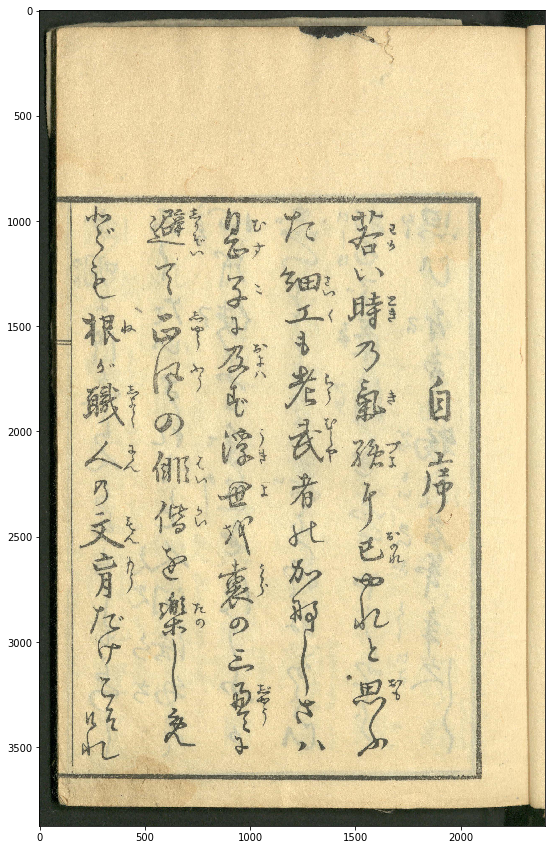

In [11]:
def displayImage(image):
    plt.figure(figsize=(15,15))
    this_img = Image.open(TRAIN/toPath(image))
    plt.imshow(this_img)
    return plt

displayImage(test_img_id)

In [12]:
def displayRandomImages(directory, paths=None , rows=3, columns=3):
    fig = plt.figure(figsize=(20, 20))
    
    # if path is not specified, display all files in directory
    if paths == None:
        paths = os.listdir(directory)
        
    for i in range(1, rows*columns + 1):
        randomNumber = random.randint(0, len(paths)-1)
        image = Image.open(directory/paths[randomNumber])
        fig.add_subplot(rows, columns, i)
        plt.imshow(image, aspect='equal')
    plt.show()

## Inspect random image from testset

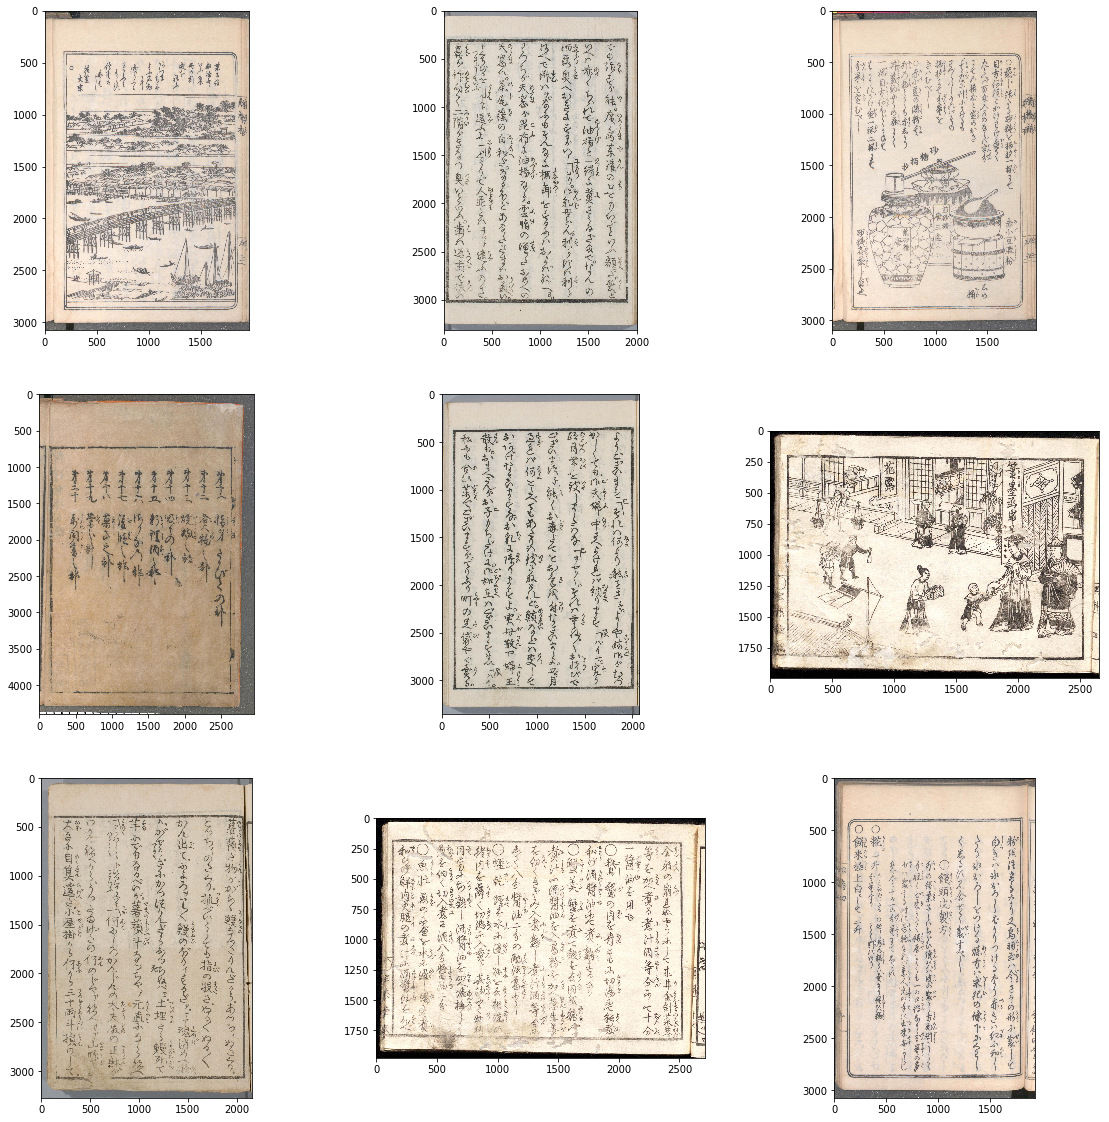

In [13]:
displayRandomImages(TRAIN)

## Check out NaN columns in training set and visualize them

In [14]:
#Check whether there are NaN columns in the training set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 2 columns):
image_id    3881 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 60.8+ KB


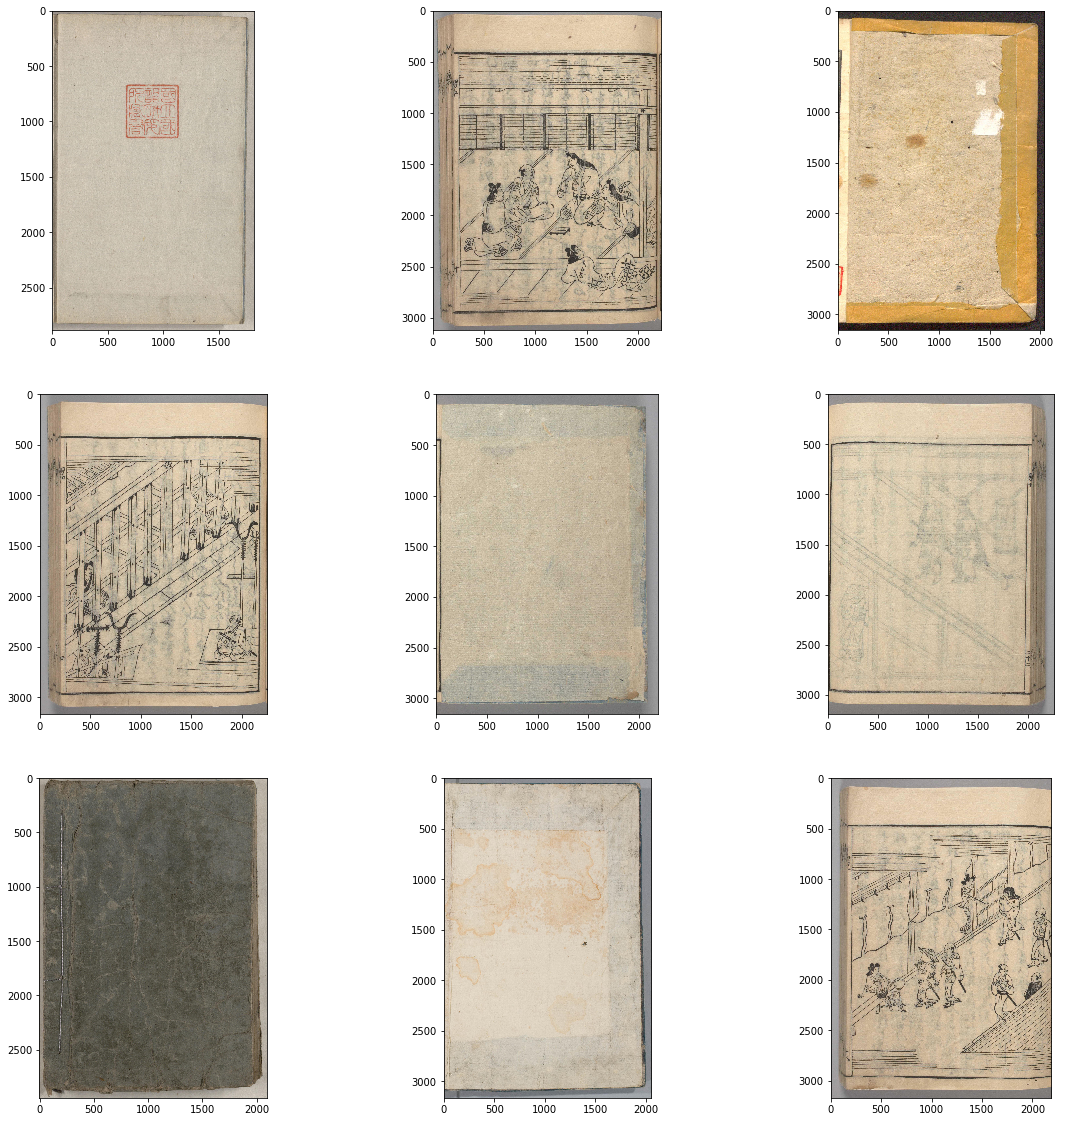

In [15]:
images_nan_labels = train_df[train_df.isna().labels]['image_id'].tolist()
images_nan_paths = [str(label)+".jpg" for label in images_nan_labels]
displayRandomImages(directory=TRAIN, paths=images_nan_paths)

Images with NaN labels are either images or empty pages

## Visualize training data

In [16]:
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(INPUT/'unicode_translation.csv').values}
unicode_list = list(unicode_map)

def unicodeToCharacter(unicode):
    return unicode_map[unicode]

# unicode to int conversion and the other way around
# unique identifier for every unicode character
def unicodeToInt(unicode):
    return unicode_list.index(unicode)

def intToUnicode(integer):
    return unicode_list[integer]

test_unicode = unicode_list[10]

print(test_unicode)
print(unicodeToCharacter(test_unicode))
print(unicodeToInt(test_unicode))
print(intToUnicode(10))

U+22CE3
𢳣
10
U+22CE3


In [17]:
def isUnicode(string):
    string = string.strip()
    if re.match("^U\+\w{4,5}$", string):
        return(True)
    else:
        return(False)
    

testUnicode1 = intToUnicode(10)
testUnicode2 = intToUnicode(20)

print(isUnicode(testUnicode1))
print(isUnicode(testUnicode2))
print(isUnicode(testUnicode1+"abc"))
print(isUnicode(testUnicode2+" "))

True
True
False
True


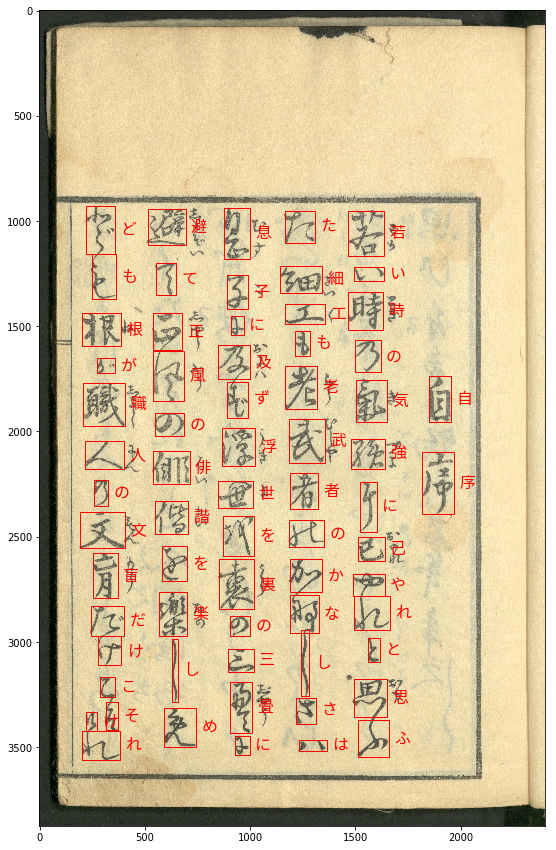

In [18]:
# take the image_id return an image with bounding boxes around each character
# image_id is the filename without the file extension (in this case .jpg)

# get all the characters and the position of the bounding boxes for an image
def getLabels(image_id):
    allLabels = train_df.loc[train_df["image_id"]==image_id].labels[0]
    allLabels = np.array(allLabels.split(" ")).reshape(-1, 5)
    return allLabels

def drawBoxAndText(ax, label):
    codepoint, x, y, w, h = label
    x, y, w, h = int(x), int(y), int(w), int(h)
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(x+w+25, y+(h/2)+20, unicodeToCharacter(codepoint),
            fontproperties=prop,
            color="r",
           size=16)
    return ax

def displayTrainingData(image_id):
    labels = getLabels(image_id)
    plt = displayImage(image_id)
    ax = plt.gca()

    for label in labels:
        ax = drawBoxAndText(ax, label)
        
    
displayTrainingData(test_img_id)

## Inspect Kuzushiji Characters
To inspect all characters in the dataset you would usually have to cut out each character. To speed up the time to run the notebook, I created a [notebook](https://www.kaggle.com/christianwallenwein/fastest-way-to-crop-all-images) that cuts out each character. I saved the results in a seperate [datataset](https://www.kaggle.com/christianwallenwein/kuzushiji-characters)

In [19]:
CHAR = Path("../input/kuzushiji-characters")

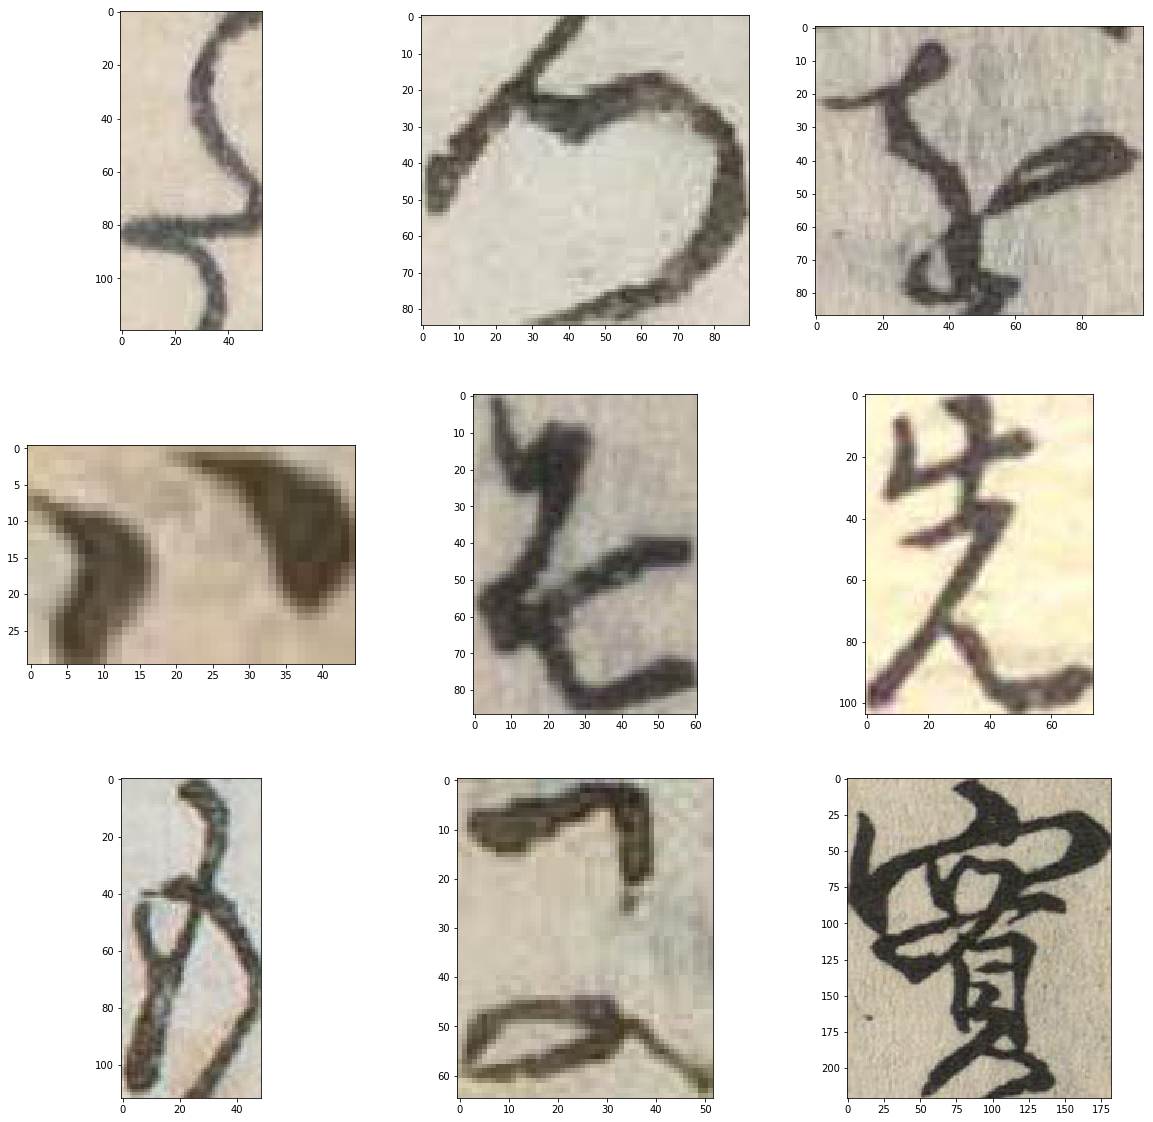

In [20]:
displayRandomImages(CHAR)

## EDA

### tSNE with 10 most common characters
based on [this](https://www.kaggle.com/aakashnain/kmnist-mnist-replacement)

In [21]:
noOfChars = 10
noOfSamplesPerChar = 100

In [22]:
width = 60
height = 80

In [23]:
def filenameToUnicodeInt(string):
    '''
    filename to integer representing a unicode
    '''
    unicode = string.split("_")[0]
    unicodeInteger = unicodeToInt(unicode)
    return unicodeInteger

In [24]:
char_filenames = os.listdir(CHAR)
chars = [filenameToUnicodeInt(filename) for filename in char_filenames]

from collections import Counter
countAll = Counter(chars)

def getNmostCommonCharacters(n=10, countAll=countAll):
    NmostCommon = countAll.most_common(n)
    NmostCommon = [unicodeID for unicodeID,frequency in NmostCommon]
    return NmostCommon

In [25]:
def getPathsFromCharID(char_id, noOfSamples=100):
    char_id = int(char_id)
    isCharIdList = [filenameToUnicodeInt(filename)==char_id for filename in os.listdir(CHAR)]
    allCharIdPaths = list(compress(os.listdir(CHAR), isCharIdList))
    return allCharIdPaths[:noOfSamples]

In [26]:
paths = [getPathsFromCharID(charID, noOfSamplesPerChar) for charID in getNmostCommonCharacters(noOfChars)]
# flatten the list
paths = sum(paths, [])

In [27]:
# create empty images and empty labels
images = np.zeros(shape=(noOfChars * noOfSamplesPerChar, width*height), dtype=np.uint8)
labels = np.zeros(shape=(noOfChars * noOfSamplesPerChar,), dtype=np.uint8)

# flatten images + make images black and white
for index, imageName in enumerate(paths):
    filepath = str(CHAR/imageName)
    img = cv2.imread(filepath)
    img = cv2.resize(img, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.reshape(-1, width*height)
    images[index] = img
    labels[index] = filenameToUnicodeInt(imageName)

In [28]:
uniqueLabels = np.array([int(i) for i in list(set(labels))], dtype=np.uint8)
uniqueUnicodeLabels = [unicodeToCharacter(intToUnicode(unicode)) for unicode in uniqueLabels]
uniqueUnicodeLabels

['し', 'て', 'と', 'な', 'り', 'に', 'か', 'の', 'は', 'を']

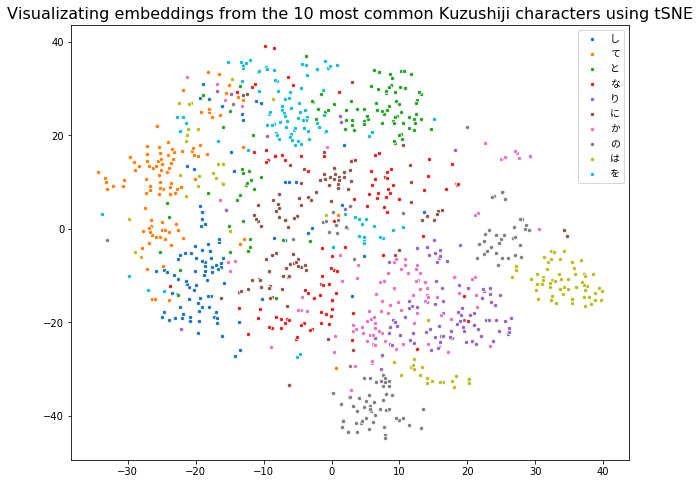

In [29]:
tsne = TSNE(n_components=2, perplexity=30)
random_train_2D = tsne.fit_transform(images)
fig = plt.figure(figsize=(10, 8))
for i in uniqueLabels:
    sns.scatterplot(random_train_2D[labels == i, 0], 
                random_train_2D[labels == i, 1], 
                label=i, s=18)
    
plt.title("Visualizating embeddings from the 10 most common Kuzushiji characters using tSNE", fontsize=16)
plt.legend(uniqueUnicodeLabels,prop=prop)
plt.show()

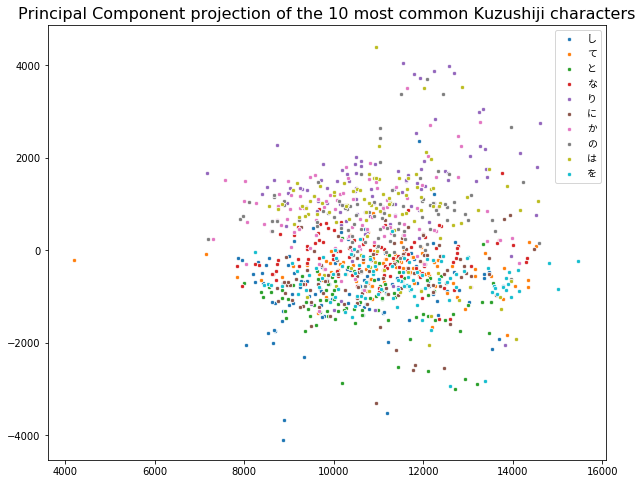

In [30]:
fig = plt.figure(figsize=(10, 8))
X_pca = TruncatedSVD(n_components=2).fit_transform(images)
for i in uniqueLabels:
    sns.scatterplot(X_pca[labels == i, 0], 
                X_pca[labels == i, 1], 
                label=i, s=18)
    
plt.title("Principal Component projection of the 10 most common Kuzushiji characters", fontsize=16)
plt.legend(uniqueUnicodeLabels,prop=prop)
plt.show()